# Gravitational waves detectability 

In [2]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
import h5py 

In [8]:
file = h5py.File("sample_2e7_design_precessing_higherordermodes_3detectors.h5",'r+')  

In [9]:
print(file)

<HDF5 file "sample_2e7_design_precessing_higherordermodes_3detectors.h5" (mode r+)>


In [13]:
list(file.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [26]:
print(file['q'])
q = file['q'][:]
print(q)
z = file['z'][:]
print(z)
mtot = file['z'][:]
print(mtot)

<HDF5 dataset "q": shape (20000000,), type "<f8">
[0.62478004 0.98665033 0.28619935 ... 0.90998157 0.2875865  0.55484975]
[2.13965943 2.43870712 1.86946125 ... 0.82663958 3.12559379 0.90834967]
[2.13965943 2.43870712 1.86946125 ... 0.82663958 3.12559379 0.90834967]


(array([4468., 4530., 4441., ..., 4448., 4467., 4627.]),
 array([0.1       , 0.10020126, 0.10040251, ..., 0.99959747, 0.99979872,
        0.99999997]),
 <BarContainer object of 4472 artists>)

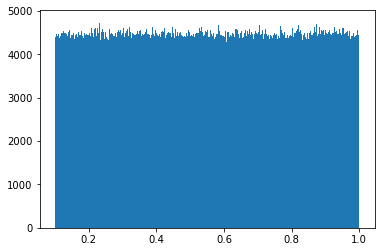

In [33]:
plt.hist(q, bins = int(len(q)**0.5))

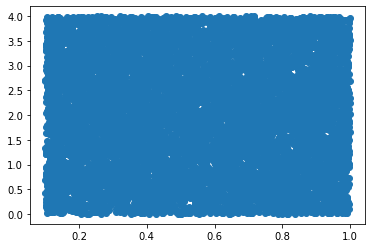

In [30]:
plt.scatter(q[0:10000], z[0:10000])

In [66]:
print(file['snr'])
snr = file['snr'][:]
print(q)
det = file['det'][:]
print(det)
mtot = file['mtot'][:]
print(mtot)

<HDF5 dataset "snr": shape (20000000,), type "<f8">
[0.62478004 0.98665033 0.28619935 ... 0.90998157 0.2875865  0.55484975]
[0 0 0 ... 0 0 0]
[906.80356183  59.10211181  44.60275026 ... 536.49129182 879.05515228
  39.57130781]


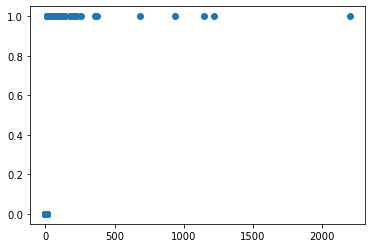

In [67]:
plt.scatter(snr[0:1000], det[0:1000])
#plt.loglog()

[]

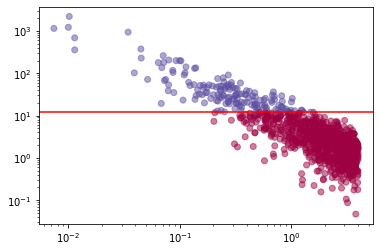

In [68]:
# color in function of detectability
plt.scatter(z[0:1000], snr[0:1000], c = det[0:1000], cmap = 'Spectral', alpha = 0.5)
plt.axhline(y=12, color='r', linestyle='-')
plt.loglog()

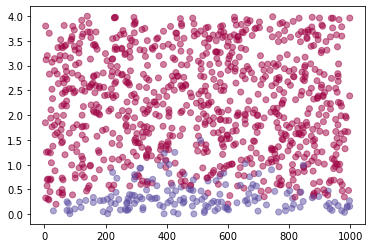

In [69]:
# color in function of detectability
plt.scatter(mtot[:1000], z[:1000], c = det[:1000], cmap = 'Spectral', alpha = 0.5)
#plt.loglog()

## Decision tree Classifier

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
drange = np.arange(1,21)  #Complete

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5) #Complete
X = np.hstack([mtot[:1000, np.newaxis], z[:1000, np.newaxis]])
y = det[:1000]
grid.fit(X, y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

best parameter choice: 4


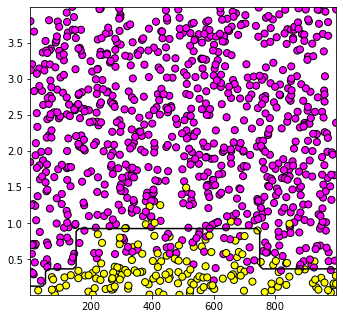

In [82]:
dt = DecisionTreeClassifier(random_state=0, max_depth=best, criterion='entropy')
dt.fit(X, y)

yprob = dt.predict_proba(X) # If we wanted probabilities rather than the discrete classes

xlim = (np.min(X[:,0]), np.max(X[:,0]))
ylim = (np.min(X[:,1]), np.max(X[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 51),np.linspace(ylim[0], ylim[1], 51))
xystack = np.vstack([xx.ravel(),yy.ravel()])
Xgrid = xystack.T

Z = dt.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(111)
im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.spring, zorder=2, edgecolor='k')

ax.contour(xx, yy, Z, [0.5], colors='k')